by Maciej Marcinkiewicz (300171) and Katarzyna Bielecka (300165)

In [59]:
import pandas as pd
import numpy as np

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, log_loss
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel

from matplotlib import pyplot as plt
import seaborn as sns

# Preparation

## Data import and preprocessing

In [14]:
# import data and get rid of IDs
df = pd.read_csv("kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


We start from removing ID and date columns as they are not providing any information which could help with price prediction - they are helpful only
from the organizational point of view for the data owner/maintainer.

In [15]:
df = df.drop(["id", "date"], axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Data analysis

If numerical data is lacking some entries they should have been filled with mean, median or any other statistical source. However there are no missing information,
thus we may procceed further with data we have got.

There is no categorical data, so we do not need to use one-hot encoder to encode any of columns.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  zipcode        21613 non-null  int64  
 15  lat            21613 non-null  float64
 16  long           21613 non-null  float64
 17  sqft_living15  21613 non-null  int64  
 18  sqft_l

Some elementary statistics about each of the columns.

In [17]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


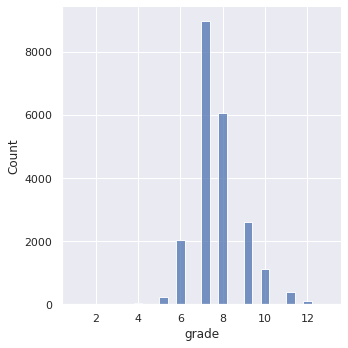

In [18]:
sns.displot(df["grade"], bins=30)
plt.show()

We can see that the area of living space (expressed in square feet) is the most correlated feature with the price. It happens it would be the most crucial
feature during predictions. Other rather highly correlated features are grade of the construction (expressed as a number in the scale 1-13) and the
square footage of house apart from basement.

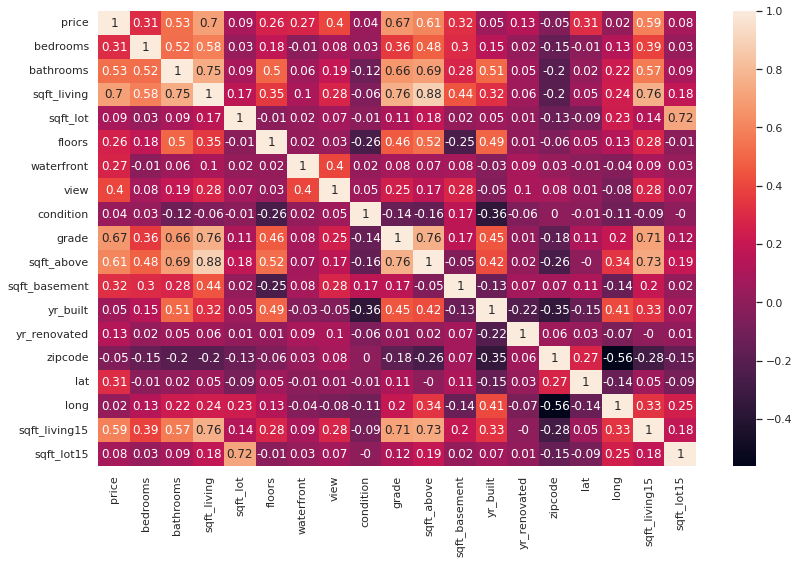

In [19]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr().round(2), annot=True)
sns.set(rc={'figure.figsize':(25,15)})
plt.tight_layout()
plt.show()

Here are scatter plots of features that are the most correlated with price. In the case of square footage it is rather hard to fit any function without very high
mean squared errors, so we should have this in mind during evaluation of the models.

In the case of the construction grade we could assume that some kind of hyperbolic function would fit rather good, however – once again – we deal with real sales data and
we should not expect getting very low mean squared errors as variance for each grade of construction is rather high.

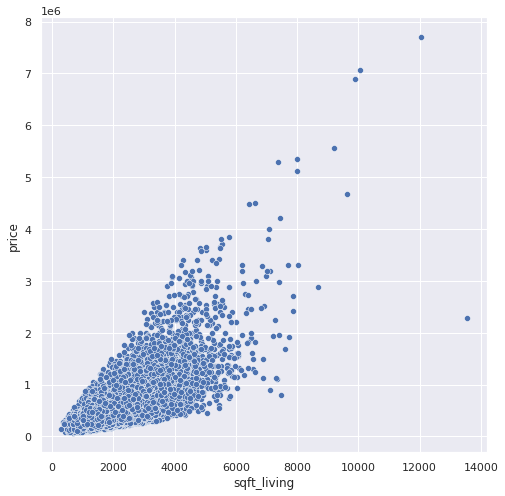

In [20]:
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x="sqft_living", y="price", data=df[["sqft_living","price"]])

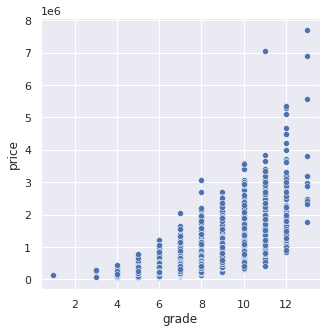

In [21]:
plt.figure(figsize=(5, 5))
ax = sns.scatterplot(x="grade", y="price", data=df[["grade","price"]])

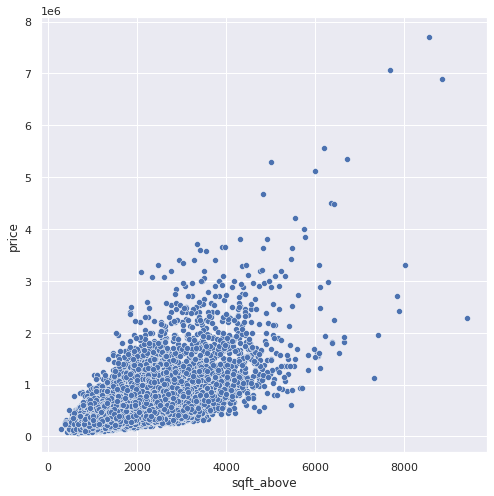

In [22]:
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x="sqft_above", y="price", data=df[["sqft_above","price"]])

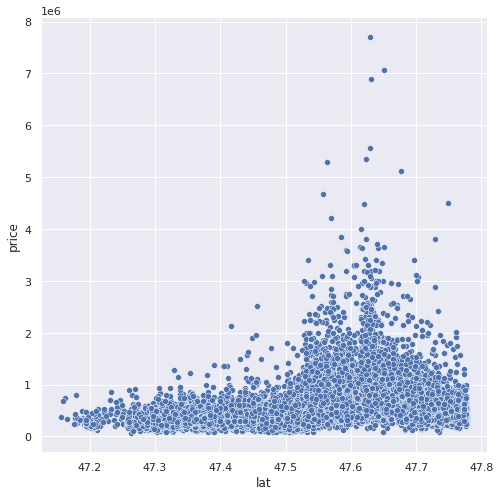

In [23]:
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x="lat", y="price", data=df[["lat","price"]])

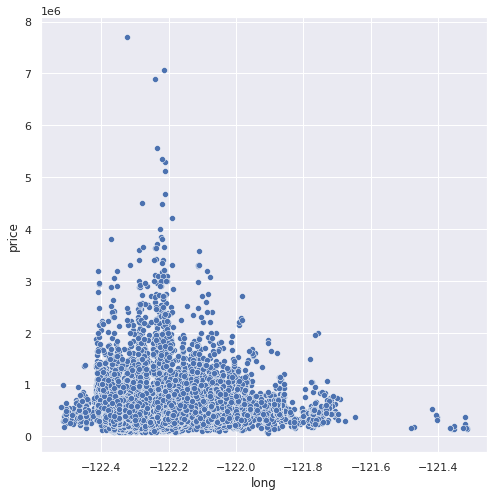

In [24]:
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x="long", y="price", data=df[["long","price"]])

# Model training based on the manual feature 

In this approach we manually choose features on which predictions of price will be based. Features choices is based on the analysis from the previous section.

## Feature selection

As we have checked, square footage of the living space, square footage without basement and construction grade are the features that highly correlate with the price.
Unfortunetaly, multicollinearity occurs between those three features meaning that they are highly correlated with each other and they may influence negatively the
predictions. We should choose features for which that does not happen.

In [25]:
features = ["sqft_living", "view"]
df_train, df_test = train_test_split(df, test_size=0.2, random_state=4)
X_train, X_test = df_train[features], df_test[features]
y_train, y_test = df_train["price"], df_test["price"]

## Selection of the best hyperparameters

### SVR

In [26]:
parameters = [
    {"kernel": ["rbf", "poly"]}
]

In [27]:
parameters = [
    {"kernel": ["poly"], "epsilon": [0.0005 * x for x in range(1, 15)], "C": [x for x in range(10, 50, 10)]}
]

In [28]:
grid_search = GridSearchCV(SVR(), param_grid=parameters, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'C': 10, 'epsilon': 0.007, 'kernel': 'poly'}


In [29]:
svr_model = SVR(**grid_search.best_params_)
svr_model.fit(X_train, y_train)

SVR(C=10, epsilon=0.007, kernel='poly')

### Random forest

In [30]:
parameters = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [31]:
random_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions = parameters, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
random_search.fit(X_train, y_train)
print(random_search.best_params_)

{'n_estimators': 31, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': True}


In [32]:
forest_model = RandomForestRegressor(**random_search.best_params_)
forest_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=70, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=31)

## Model predictions and evaluation

In [33]:
y_train_pred_svr = svr_model.predict(X_train)
y_test_pred_svr = svr_model.predict(X_test)

y_train_pred_forest = forest_model.predict(X_train)
y_test_pred_forest = forest_model.predict(X_test)

### Evaluation for SVR

In [34]:
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_svr))
print(f"Root-mean-square error for training data: {rmse_train}")

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_svr))
print(f"Root-mean-square error for test data: {rmse_test}")

Root-mean-square error for training data: 312311.8307968626
Root-mean-square error for test data: 263789.81371202384


In [35]:
mae_train = mean_absolute_error(y_train, y_train_pred_svr)
print(f"Mean absolute error for training data: {mae_train}")

mae_test = mean_absolute_error(y_test, y_test_pred_svr)
print(f"Mean absolute error for test data: {mae_test}")

Mean absolute error for training data: 171509.28071562762
Mean absolute error for test data: 169463.31405050078


In [36]:
r2_train = r2_score(y_train, y_train_pred_svr)
print(f"R2 score for training data: {r2_train}")

r2_test = r2_score(y_test, y_test_pred_svr)
print(f"R2 score for test data: {r2_test}")

R2 score for training data: 0.2835150384764722
R2 score for test data: 0.4619956499970923


### Evaluation for random forest

In [37]:
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_forest))
print(f"Root-mean-square error for training data: {rmse_train}")

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_forest))
print(f"Root-mean-square error for test data: {rmse_test}")

Root-mean-square error for training data: 219488.86936409757
Root-mean-square error for test data: 246737.93558008375


In [38]:
mae_train = mean_absolute_error(y_train, y_train_pred_forest)
print(f"Mean absolute error for training data: {mae_train}")

mae_test = mean_absolute_error(y_test, y_test_pred_forest)
print(f"Mean absolute error for test data: {mae_test}")

Mean absolute error for training data: 152116.89196039326
Mean absolute error for test data: 164274.23263868477


In [39]:
r2_train = r2_score(y_train, y_train_pred_forest)
print(f"R2 score for training data: {r2_train}")

r2_test = r2_score(y_test, y_test_pred_forest)
print(f"R2 score for test data: {r2_test}")

R2 score for training data: 0.646120659185011
R2 score for test data: 0.5293028179974439


# Model training based on the automatic feature selection

## Feature selection

In this case we will use sklearn's SelectFromModel method to select features. It uses a fitted model (in this case random forest) and selects
features by checking importance weights – if they exceed a ceratain threshold, the checked feature is selected.

In [40]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=4)
X_train, X_test = df_train.drop("price", axis=1).values, df_test.drop("price", axis=1).values
y_train, y_test = df_train["price"].values, df_test["price"].values

In [41]:
#threshold = 5 * 10 ** (-3) --- delete this for now, as we got worse results with this >:(
model = RandomForestRegressor()
model.fit(X_train, y_train)
selection = SelectFromModel(model,prefit=True)

In [42]:
X_train = selection.transform(X_train)
X_test = selection.transform(X_test)

## Selection of the best hyperparameters

### SVR

In [43]:
parameters = [
    {"kernel": ["rbf"], "epsilon": [0.0005 * x for x in range(1, 15)], "C": [x for x in range(10, 50, 10)]},
    {"kernel": ["poly"], "epsilon": [0.0005 * x for x in range(1, 15)], "C": [x for x in range(10, 50, 10)]}
]

In [44]:
grid_search = GridSearchCV(SVR(), param_grid=parameters, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'C': 10, 'epsilon': 0.0005, 'kernel': 'poly'}


In [45]:
svr_model = SVR(**grid_search.best_params_)
svr_model.fit(X_train, y_train)

SVR(C=10, epsilon=0.0005, kernel='poly')

### Random forest

In [46]:
parameters = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)],
                'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

In [47]:
random_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions = parameters, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
random_search.fit(X_train, y_train)
print(random_search.best_params_)

{'n_estimators': 115, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


In [48]:
forest_model = RandomForestRegressor(**random_search.best_params_)
forest_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=115)

## Model predictions and evaluation

In [49]:
y_train_pred_svr = svr_model.predict(X_train)
y_test_pred_svr = svr_model.predict(X_test)

In [50]:
y_train_pred_forest = forest_model.predict(X_train)
y_test_pred_forest = forest_model.predict(X_test)

### Evaluation for SVR

In [51]:
rmse_train = mean_squared_error(y_train, y_train_pred_svr, squared=False)
print(f"Root-mean-square error for training data: {rmse_train}")

rmse_test = mean_squared_error(y_test, y_test_pred_svr, squared=False)
print(f"Root-mean-square error for test data: {rmse_test}")

Root-mean-square error for training data: 298148.05544360244
Root-mean-square error for test data: 270420.67880131194


In [52]:
mae_train = mean_absolute_error(y_train, y_train_pred_svr)
print(f"Mean absolute error for training data: {mae_train}")

mae_test = mean_absolute_error(y_test, y_test_pred_svr)
print(f"Mean absolute error for test data: {mae_test}")

Mean absolute error for training data: 175199.05676988448
Mean absolute error for test data: 173302.03567572552


In [53]:
r2_train = r2_score(y_train, y_train_pred_svr)
print(f"R2 score for training data: {r2_train}")

r2_test = r2_score(y_test, y_test_pred_svr)
print(f"R2 score for test data: {r2_test}")

R2 score for training data: 0.3470285856349413
R2 score for test data: 0.4346081525236979


### Evaluation for random forest

In [54]:
rmse_train = mean_squared_error(y_train, y_train_pred_forest, squared=False)
print(f"Root-mean-square error for training data: {rmse_train}")

rmse_test = mean_squared_error(y_test, y_test_pred_forest, squared=False)
print(f"Root-mean-square error for test data: {rmse_test}")

Root-mean-square error for training data: 85004.61219615766
Root-mean-square error for test data: 146630.14404361037


In [55]:
mae_train = mean_absolute_error(y_train, y_train_pred_forest)
print(f"Mean absolute error for training data: {mae_train}")

mae_test = mean_absolute_error(y_test, y_test_pred_forest)
print(f"Mean absolute error for test data: {mae_test}")

Mean absolute error for training data: 43955.8877319518
Mean absolute error for test data: 78777.39697184462


In [56]:
r2_train = r2_score(y_train, y_train_pred_forest)
print(f"R2 score for training data: {r2_train}")

r2_test = r2_score(y_test, y_test_pred_forest)
print(f"R2 score for test data: {r2_test}")

R2 score for training data: 0.9469219220796721
R2 score for test data: 0.8337673733679248


# Summary
After analysis of metrics of both SVR and Random forest methods we can conclude that random forest performed better overall – all metrics point to better results. R2 on the 
level of 0.8 and 0.9 indicates that the predicted values is fitted well with the real values. RMSE and MAE values may look quite large however we must take in account here 
that the standard deviation of the data set is rather big, and so it causes the occurance of large errors. 
In comparison, R2 for SVR is 2-3 times smaller than the other method, as well as other metrics (MAE, RMSE) indicate approximately 2 times worse accuracy.

In case of this dataset it is not very easy task to fit SVM to the samples we have got – possibly linear kernel would obtain better result, however for most of the cases we
have dealt with timeout during model fitting and we could not test that kernel. For some basic settings of the model and small number of columns it produced some results 
which were better than for default polynomial and RBF kernels.

The last interesting part is automatic feature selection and its inclusion of latidude and longitude. Initially we excluded those two as too random features for such a
small geographical area of analaysis. However it significantly increased the quality of the trained models.